In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM

In [6]:
def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [7]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

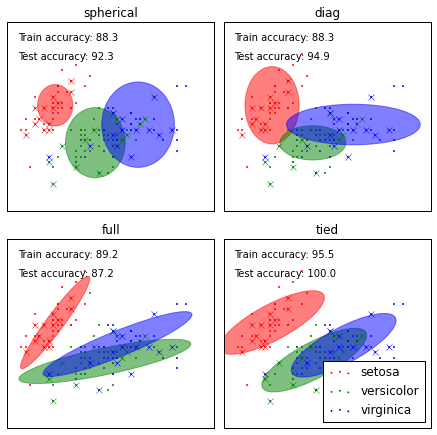

In [8]:
# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * n_classifiers / 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, classifier) in enumerate(classifiers.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    classifier.means_ = np.array([X_train[y_train == i].mean(axis=0)
                                  for i in xrange(n_classes)])

    # Train the other parameters using the EM algorithm.
    classifier.fit(X_train)

    h = plt.subplot(2, n_classifiers / 2, index + 1)
    make_ellipses(classifier, h)

    for n, color in enumerate('rgb'):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], 0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate('rgb'):
        data = X_test[y_test == n]
        plt.plot(data[:, 0], data[:, 1], 'x', color=color)

    y_train_pred = classifier.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = classifier.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(loc='lower right', prop=dict(size=12))


plt.show()